In [1]:
%reload_ext autoreload
%autoreload 1
from model_files.model import MushroomClassifier,MushroomDataModule
import os, shutil
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import cv2
import joblib
import numpy as np
import torch
from torchvision import datasets, transforms
from torchvision.models import resnet18,ResNet18_Weights
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
import pytorch_lightning as ptl
from torchmetrics.classification import Accuracy
from torch.utils.data import Subset
from PIL import Image
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import model_files.tuning as tunes
from ray import tune
from ray.tune.stopper import MaximumIterationStopper
from ray.tune.search.optuna import OptunaSearch
from ray import train
%aimport model_files.tuning
%aimport model_files.model

In [2]:
BASE_FIG_SIZE=(8.5,5)

In [3]:
files=os.listdir("Mushrooms")
genuses = [file for file in files]
genus_data_count={}
for genus in genuses:
    pics=os.listdir(f"Mushrooms/{genus}")
    genus_data_count[genus]=len([pic for pic in pics])

In [4]:
genus_data_count

{'Boletus': 1073,
 'Cortinarius': 836,
 'Entoloma': 364,
 'Hygrocybe': 316,
 'Lactarius': 1563,
 'Russula': 1148,
 'Agaricus': 353,
 'Amanita': 750,
 'Suillus': 311}

<Axes: >

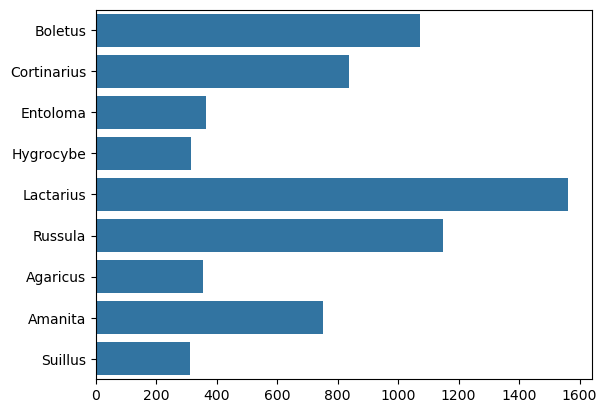

In [5]:
sns.barplot(genus_data_count,orient='y')

sizes

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

In [7]:
tb_logger = ptl.loggers.TensorBoardLogger('logs')

In [8]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    min_delta=0.001,
)

In [9]:
current_directory = os.getcwd()
stopper = MaximumIterationStopper(1)
tuner = tune.Tuner(
    trainable=tune.with_resources(
        tune.with_parameters(
            tunes.TrainableCV,
            model=MushroomClassifier,
            dm=MushroomDataModule,
            metric="val_loss",
            logger=tb_logger,
            callbacks=[early_stopping_callback],
        ),
        resources={"CPU": 2, "GPU": 1},
    ),
    run_config=train.RunConfig(
        stop=stopper,
        storage_path=f"{current_directory}/logs/ray/",
        name="tunning",
        checkpoint_config=train.CheckpointConfig(
            checkpoint_at_end=False,
        ),
    ),
    tune_config=tune.TuneConfig(
        search_alg=OptunaSearch(),
        mode="min",
        metric="score",
        num_samples=2,
    ),
    param_space={
        "batch_size": tune.randint(32, 128),
        "img_size":tune.randint(150,300),
        "max_epochs": tune.randint(5,35),
        "learning_rate": tune.loguniform(0.00001, 0.01),
        "num_classes": 9,
        "architecture": tune.choice(["resnet18","squeezenet","google"]),
        "optimizer": tune.choice(["adam","sgd"]),
        "l2":tune.loguniform(1e-6,1)
    },
)

In [10]:
shutil.rmtree(f"{current_directory}/logs/ray/")
shutil.rmtree("/home/gediminas/ray_results/tunning/")
results = tuner.fit()
# best_params = results.get_best_result().config
# joblib.dump(best_params,"temp/best_params.joblib")

(TrainableCV pid=19000) GPU available: True (cuda), used: True
(TrainableCV pid=19000) TPU available: False, using: 0 TPU cores
(TrainableCV pid=19000) IPU available: False, using: 0 IPUs
(TrainableCV pid=19000) HPU available: False, using: 0 HPUs
(TrainableCV pid=19000) Missing logger folder: logs/lightning_logs
(TrainableCV pid=19000) 2023-12-10 12:02:23.055103: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(TrainableCV pid=19000) 2023-12-10 12:02:23.056626: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
(TrainableCV pid=19000) 2023-12-10 12:02:23.076107: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN w

Sanity Checking: |          | 0/? [00:00<?, ?it/s]


(TrainableCV pid=19000) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(TrainableCV pid=19000) 
(TrainableCV pid=19000)   | Name  | Type      | Params
(TrainableCV pid=19000) ------------------------------------
(TrainableCV pid=19000) 0 | model | GoogLeNet | 5.6 M 
(TrainableCV pid=19000) ------------------------------------
(TrainableCV pid=19000) 5.6 M     Trainable params
(TrainableCV pid=19000) 0         Non-trainable params
(TrainableCV pid=19000) 5.6 M     Total params
(TrainableCV pid=19000) 22.437    Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


(TrainableCV pid=19000) /home/gediminas/anaconda3/envs/DL/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
(TrainableCV pid=19000)   return F.conv2d(input, weight, bias, self.stride,


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s]
                                                                           


(TrainableCV pid=19000) /home/gediminas/anaconda3/envs/DL/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (42) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 42/42 [00:09<00:00,  4.40it/s, v_num=0]
(TrainableCV pid=19000) 
Validation: |          | 0/? [00:00<?, ?it/s]
(TrainableCV pid=19000) 
Validation DataLoader 0:   7%|▋         | 1/14 [00:00<00:00, 19.08it/s]
(TrainableCV pid=19000) 
Validation DataLoader 0:  14%|█▍        | 2/14 [00:00<00:00, 17.76it/s]
(TrainableCV pid=19000) 
Validation DataLoader 0:  29%|██▊       | 4/14 [00:00<00:00, 17.07it/s]
(TrainableCV pid=19000) 
Validation DataLoader 0:  36%|███▌      | 5/14 [00:00<00:00, 16.97it/s]
(TrainableCV pid=19000) 
Validation DataLoader 0:  43%|████▎     | 6/14 [00:00<00:00,  8.34it/s]
(TrainableCV pid=19000) 
Validation DataLoader 0:  50%|█████     | 7/14 [00:00<00:00,  8.95it/s]
(TrainableCV pid=19000) 
Validation DataLoader 0:  64%|██████▍   | 9/14 [00:01<00:00,  8.57it/s]
(TrainableCV pid=19000) 
Validation DataLoader 0:  71%|███████▏  | 10/14 [00:01<00:00,  9.01it/s]
(TrainableCV pid=19000) 
Validation DataLoader 0:  79%|███████▊  | 11/14 [00:01<00:00,

2023-12-10 12:03:24,131	WARNING tune.py:186 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 


Epoch 1: 100%|██████████| 42/42 [00:09<00:00,  4.46it/s, v_num=0]
(TrainableCV pid=19000) 
Validation: |          | 0/? [00:00<?, ?it/s]


In [13]:
%load_ext tensorboard
%tensorboard --logdir logs

In [15]:
best_params

{'batch_size': 91,
 'max_epochs': 11,
 'learning_rate': 3.989079646553492e-05,
 'num_classes': 9,
 'architecture': 'resnet18',
 'optimizer': 'adam',
 'l2': 1.620014913053158e-06}

In [16]:
best_model,best_dm=tunes.config_models(best_params,MushroomClassifier,MushroomDataModule)

In [10]:
# trainer = ptl.Trainer(
#     max_epochs=35,
#     accelerator="gpu",
#     callbacks=[early_stopping_callback],
#     logger=tb_logger,
# )

In [18]:
trainer.fit(best_model,best_dm)

2023-12-08 13:53:02.031575: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-08 13:53:02.033126: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-08 13:53:02.060113: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 13:53:02.060144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 13:53:02.061030: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/gediminas/anaconda3/envs/DL/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
/home/gediminas/anaconda3/envs/DL/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (45) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=11` reached.


In [19]:
trainer.test(best_model,best_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8064035773277283
        test_loss           0.6258587837219238
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.6258587837219238, 'test_accuracy': 0.8064035773277283}]